# Super-resolution

> Using the Convolutional ResNet architecture to achieve image super-resolution, instead of classification

Adapted from

- [https://youtu.be/z1In7QaG0fg?si=4ARBE2uZ5D7ubc4u&t=2897](https://youtu.be/z1In7QaG0fg?si=4ARBE2uZ5D7ubc4u&t=2897)

In [1]:
# |default_exp super_rez

In [21]:
# |export
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch import nn
from torch.nn import init
from torch.optim import lr_scheduler
from torchmetrics.classification import MulticlassAccuracy

from slowai.convs import def_device
from slowai.learner import DataLoaders, DeviceCB, MetricsCB, ProgressCB, TrainLearner
from slowai.sgd import BatchSchedulerCB
from slowai.tinyimagenet_a import (
    denorm,
    fill,
    lr_find,
    norm,
    tiny_imagenet_dataset_dict,
)
from slowai.utils import show_images

The challenge of this module is to: (a) upscale a 32x32 image to a 64x64 image while (b) un-erasing randomly cropped portions of the training data.

In [22]:
# |export
preprocess_trn = [
    T.Pad(4, fill=fill),
    T.TrivialAugmentWide(fill=fill),
    T.RandomCrop(64, fill=fill),
    T.RandomHorizontalFlip(),
    T.PILToTensor(),
]
preprocess_tst = [T.PILToTensor()]
postprocess = T.Compose([T.ConvertImageDtype(torch.float), norm])

In [23]:
# |export
def preprocess(examples, pipe, erase):
    p = T.Compose(pipe)
    imgs = []
    for img in examples["image"]:
        img = img.convert("RGB")
        img_hr = p(img)
        # Note that this resizing discards details but retains the image
        # dimensions, which makes it slightly easier to design the network
        img_lr = TF.resize(img_hr, (32, 32), antialias=True)
        img_lr = TF.resize(img_lr, (64, 64), antialias=False)
        img_hr, img_lr = map(postprocess, (img_hr, img_lr))
        imgs.append((img_hr, img_lr))
    imgs_hr, imgs_lr = map(torch.stack, zip(*imgs))
    return {"image_high_rez": imgs_hr, "image_low_rez": imgs_lr, "idx": examples["idx"]}

In [24]:
# |export
def get_imagenet_super_rez_dls(bs=512):
    dsd = tiny_imagenet_dataset_dict()
    dsd["train"].set_transform(partial(preprocess, pipe=preprocess_trn, erase=True))
    dsd["train"] = dsd["train"].shuffle()
    dsd["test"] = (
        dsd["test"]
        .map(
            partial(preprocess, pipe=preprocess_tst, erase=False),
            batched=True,
            # We need to remove images because some are black and white, causing
            # collation errors. Note that this column is unused, but it still
            # causes problems because it's available but not compatible
            remove_columns=["image"],
        )
        .with_format("torch")
    )
    columns = ["image_low_rez", "image_high_rez"]
    return DataLoaders.from_dsd(dsd, bs=bs).listify(columns=columns)

In [25]:
%%time
dls = get_imagenet_super_rez_dls(1024)
xb, yb = dls.peek()

CPU times: user 4.71 s, sys: 412 ms, total: 5.13 s
Wall time: 4.33 s


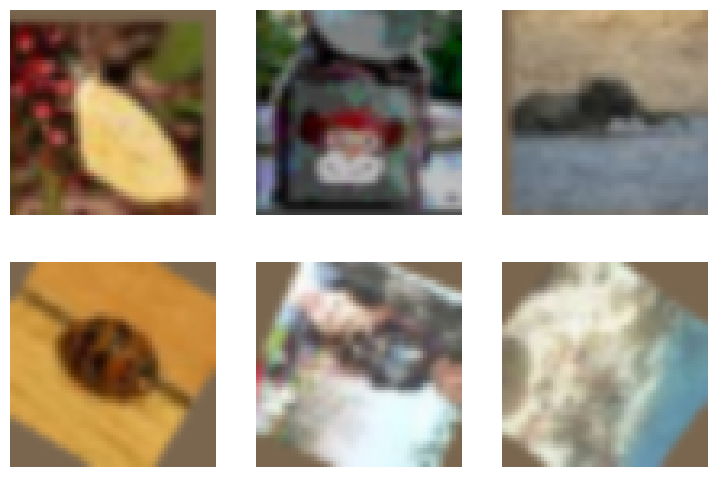

In [28]:
show_images(denorm(xb[:6, ...]))

First, let's clean up the `ResidualConvBlock`. It seems that there was an issue where the original `Conv` helper did activation, then normalization. It seems [it should be the other way around.](https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/).

Here's the shared model code.

In [8]:
# |export
class Conv(nn.Conv2d):
    def __init__(self, c_in, c_out, stride=2, ks=3, **kwargs):
        super().__init__(
            c_in,
            c_out,
            stride=stride,
            kernel_size=ks,
            padding=ks // 2,
            **kwargs,
        )

In [ ]:
# |export
class ResidualConvBlock(nn.Module):
    """Convolutional block with residual links without a final activation"""

    def __init__(self, c_in, c_out, stride=2, ks=3, with_final_activation=True):
        super().__init__()
        self.stride = stride
        self.c_in = c_in
        self.c_out = c_out
        self.with_final_activation = with_final_activation
        # Non-residual circuit
        # -- Note that the bias term is False because the normalization term makes
        # -- this redundant. See: https://tinyurl.com/mutwfn32
        self.convs = nn.Sequential(
            Conv(c_in, c_out, bias=False, stride=1, ks=ks),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
            Conv(c_out, c_out, bias=False, stride=stride, ks=ks),
            nn.BatchNorm2d(c_out),
        )
        # Residual circuit
        self.id_conv = nn.Conv2d(c_in, c_out, stride=1, kernel_size=1)

    def forward(self, x):
        x_orig = x.clone()
        # Non-residual circuit
        x = self.convs(x)
        # Residual circuit
        if self.stride == 2:
            x_orig = F.avg_pool2d(x_orig, kernel_size=2, ceil_mode=True)
        elif self.stride > 2:
            raise ValueError
        else:
            assert self.stride == 1
        if self.c_in != self.c_out:
            x_orig = self.id_conv(x_orig)
        # Combine circuits
        x += x_orig
        if self.with_final_activation:
            x = F.relu(x)
        return x

In [10]:
# |export
class UpsamplingResidualConvBlock(ResidualConvBlock):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert self.stride == 1
        self.upsampler = nn.UpsamplingNearest2d(scale_factor=2)

    def forward(self, x):
        x = self.upsampler(x)
        x = super().forward(x)
        return x

In [11]:
# |export
class KaimingMixin:
    @staticmethod
    def init_kaiming(m):
        if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
            init.kaiming_normal_(m.weight)

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(cls.init_kaiming)
        return model

Here's the training code

In [12]:
# |export
def train(
    model, dls, lr=4e-3, n_epochs=25, extra_cbs=[MetricsCB()], loss_fn=F.mse_loss
):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        DeviceCB(),
        ProgressCB(plot=True),
        scheduler,
        *extra_cbs,
    ]
    learner = TrainLearner(
        model,
        dls,
        loss_fn,
        lr=lr,
        cbs=cbs,
        opt_func=partial(torch.optim.AdamW, eps=1e-5),
    )
    learner.fit(n_epochs)
    return model

In [13]:
# |export
def viz(xb, yb, yp, n=3):
    fig, axs = plt.subplots(n, 3)
    for i in range(n):
        for ax, im, title in [
            (axs[i, 0], yb[i, ...], "Ground Truth"),
            (axs[i, 1], xb[i, ...], "Downsampled"),
            (axs[i, 2], yp[i, ...], "Upsampled"),
        ]:
            im = denorm(im).permute(1, 2, 0).clip(0.0, 1.0)
            ax.imshow(im)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set(title=title)
    fig.tight_layout()

# Different approaches to super-resolution

## Autoencoder

Recall that we had __poor results__ in FashionMNIST, so temper your expectations.

In [16]:
# |export
class AutoEncoder(nn.Sequential, KaimingMixin):
    """Project into a hidden space and reproject into the original space"""

    def __init__(self, nfs: list[int] = (32, 64, 128, 256, 512, 1024)):
        layers = [ResidualConvBlock(3, nfs[0], ks=5, stride=1)]
        cs = list(zip(nfs, nfs[1:]))
        for c_in, c_out in cs:
            l = ResidualConvBlock(c_in, c_out, stride=2)
            layers.append(l)
        for c_out, c_in in reversed(cs):
            l = UpsamplingResidualConvBlock(c_in, c_out, stride=1)
            layers.append(l)
        l = ResidualConvBlock(nfs[0], 3, stride=1, with_final_activation=False)
        layers.append(l)
        super().__init__(*layers)

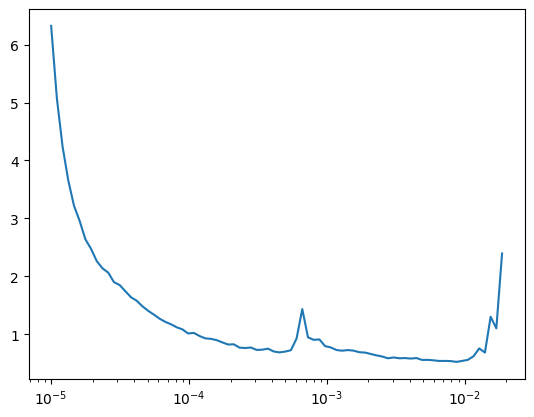

In [17]:
lr_find(AutoEncoder.kaiming(), dls, gamma=1.1, start_lr=1e-5, loss_fn=F.mse_loss)

loss,epoch,train
0.845,0,train
0.558,0,eval
0.487,1,train
0.432,1,eval
0.387,2,train
0.354,2,eval
0.325,3,train
0.325,3,eval
0.286,4,train
0.270,4,eval


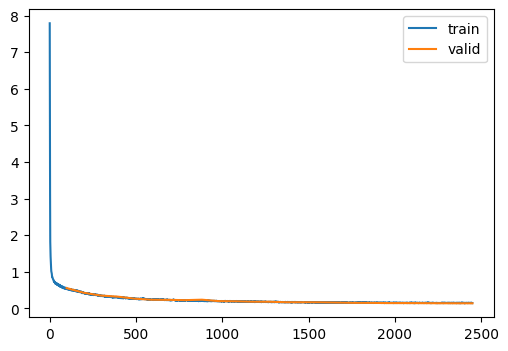

In [18]:
ae = train(AutoEncoder.kaiming(), dls)

In [19]:
torch.save(ae, "../models/tiny-image-resnet-ae.pt")
ae = torch.load("../models/tiny-image-resnet-ae.pt")

In [20]:
with torch.no_grad():
    yp = ae(xb.to(def_device)).cpu()

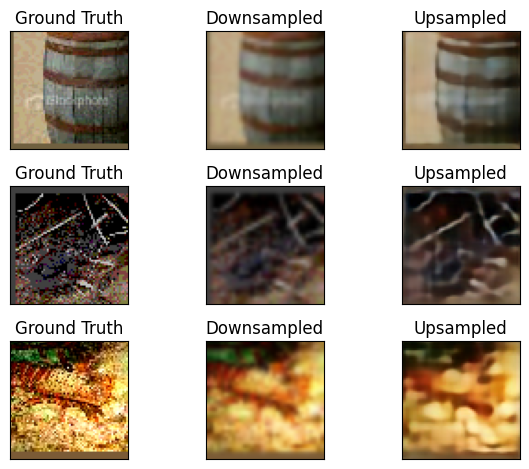

In [21]:
viz(xb, yb, yp)

Not much better than the original.

In [22]:
del ae

## U-net

This is nearly identical except that, for a particular up-sampling block, the logits from the same scale down-sampling are added or concatenated.

In [14]:
# |export
class TinyUnet(nn.Module, KaimingMixin):
    def __init__(
        self,
        nfs: list[int] = (32, 64, 128, 256, 512, 1024),
        n_blocks=(3, 2, 2, 1, 1),
    ):
        super().__init__()
        self.start = ResidualConvBlock(3, nfs[0], ks=5, stride=1)
        cs = list(zip(nfs, nfs[1:]))
        self.downsamplers = nn.ModuleList()
        for c_in, c_out in cs:
            ld = ResidualConvBlock(c_in, c_out, stride=2)
            self.downsamplers.append(ld)
        self.upsamplers = nn.ModuleList()
        for c_out, c_in in reversed(cs):
            lu = UpsamplingResidualConvBlock(c_in, c_out, stride=1)
            self.upsamplers.append(lu)
        self.final = ResidualConvBlock(nfs[0], 3, stride=1, with_final_activation=False)

    def forward(self, x):
        x = self.start(x)
        x_orig = x.clone()
        xs = []
        for l in self.downsamplers:
            x = l(x)
            xs.append(x.clone())
        for xu, l in zip(reversed(xs), self.upsamplers):
            x = l(x + xu)
        x = self.final(x + x_orig)
        return x

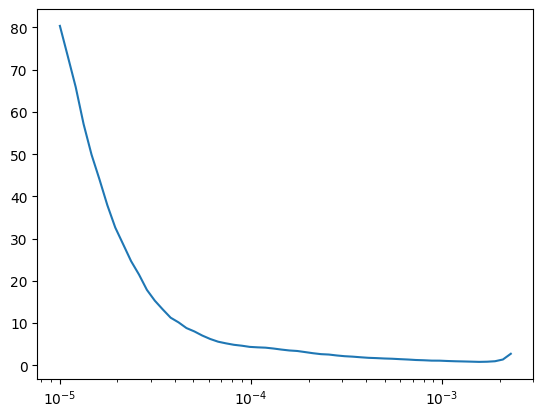

In [24]:
lr_find(TinyUnet.kaiming(), dls, gamma=1.1, start_lr=1e-5, loss_fn=F.mse_loss)

loss,epoch,train
1.265,0,train
0.377,0,eval
0.249,1,train
0.196,1,eval
0.173,2,train
0.149,2,eval
0.142,3,train
0.124,3,eval
0.128,4,train
0.119,4,eval


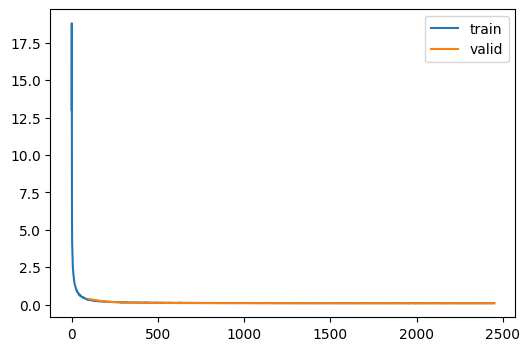

In [26]:
un = train(TinyUnet.kaiming(), dls)

In [27]:
torch.save(un, "../models/tiny-image-resnet-un.pt")
un = torch.load("../models/tiny-image-resnet-un.pt")

In [28]:
with torch.no_grad():
    yp = un(xb.to(def_device)).cpu()

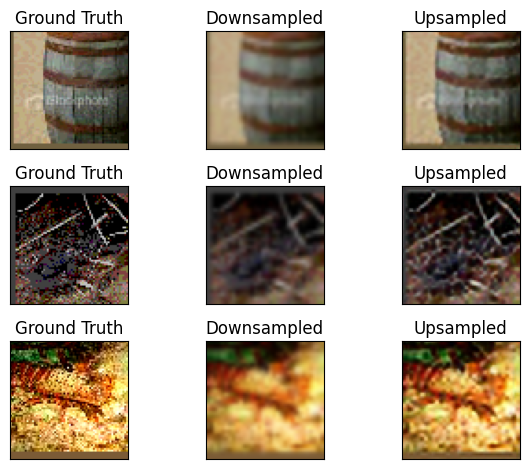

In [29]:
viz(xb, yb, yp)

In [30]:
del un

## U-net with perceptual loss

### First, let's train a model with an identical downsampling circuit and a classification head

In [31]:
# |export
class TinyImageResNet4(nn.Sequential, KaimingMixin):
    """Convolutional classification model"""

    def __init__(self, nfs: list[int] = (32, 64, 128, 256, 512, 1024)):
        self.conv_layers = [ResidualConvBlock(3, nfs[0], ks=5, stride=1)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            self.conv_layers.append(ResidualConvBlock(c_in, c_out, stride=2))
        clf_head = (
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, 200),
        )
        super().__init__(*self.conv_layers, *clf_head)

In [32]:
dls_clf = DataLoaders.from_dsd(dls.splits).listify(["image_high_rez", "idx"])
dls_clf.bs = 1024

MulticlassAccuracy,loss,epoch,train
0.064,4.714,0,train
0.133,4.083,0,eval
0.138,4.059,1,train
0.200,3.607,1,eval
0.197,3.648,2,train
0.223,3.540,2,eval
0.243,3.372,3,train
0.289,3.102,3,eval
0.284,3.136,4,train
0.292,3.084,4,eval


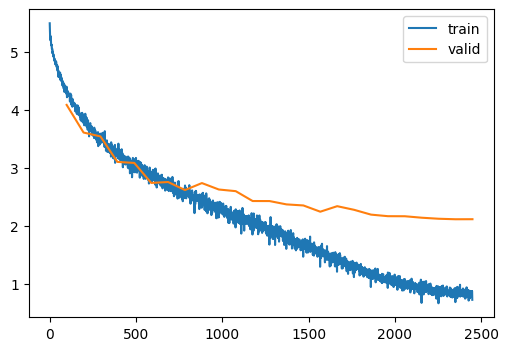

In [34]:
m = MetricsCB(MulticlassAccuracy(num_classes=200))
clf = train(
    TinyImageResNet4.kaiming(),
    dls_clf,
    loss_fn=F.cross_entropy,
    lr=1e-2,
    n_epochs=25,
    extra_cbs=[m],
)

In [35]:
torch.save(clf, "../models/tiny-image-resnet-4.pt")
clf = torch.load("../models/tiny-image-resnet-4.pt")

In [36]:
@torch.no_grad()
def get_clf_features(x):
    x = xb.cuda()
    for l in clf.conv_layers[:4]:
        x = l(x)
    x = torch.flatten(x)
    return x

Now, we can train using these "perceptual" features

In [37]:
def custom_loss(y, y_pred):
    """Compositive MSE and perceputal loss function"""
    perceptual_loss = F.mse_loss(
        get_clf_features(y),
        get_clf_features(y_pred),
    )
    return F.mse_loss(y, y_pred) + (0.1 * perceptual_loss)

Now, we can train with this loss function

loss,epoch,train
2.163,0,train
0.460,0,eval
0.315,1,train
0.238,1,eval
0.204,2,train
0.169,2,eval
0.162,3,train
0.139,3,eval
0.141,4,train
0.123,4,eval


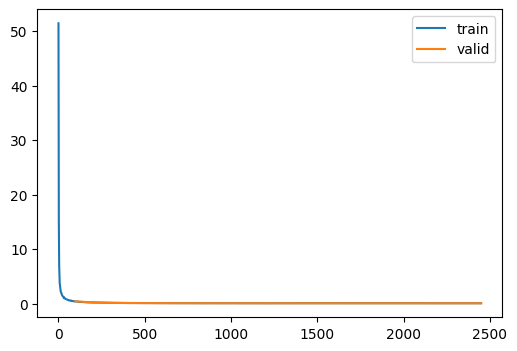

In [39]:
unp = train(TinyUnet.kaiming(), dls, loss_fn=custom_loss)

In [40]:
with torch.no_grad():
    yp = unp(xb.to(def_device)).cpu()

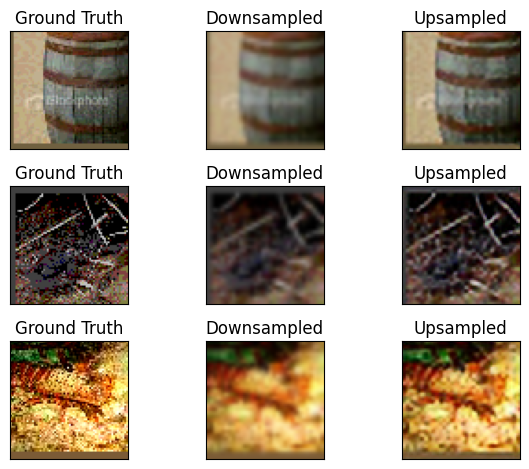

In [41]:
viz(xb, yb, yp)

In [43]:
torch.save(unp, "../models/tiny-image-resnet-un-p.pt")
unp = torch.load("../models/tiny-image-resnet-un-p.pt")

In [44]:
del unp

And, finally, train with the same features from the classifier in the downsampler path

In [45]:
# |export
def initialize_unet_weights_with_clf_weights(c, unet):
    l0, *ls, _, _, _ = c
    unet.start.load_state_dict(l0.state_dict())
    for lc, lu in zip(ls, unet.downsamplers):
        lu.load_state_dict(lc.state_dict())
    return unet

loss,epoch,train
1.419,0,train
0.420,0,eval
0.266,1,train
0.183,1,eval
0.159,2,train
0.130,2,eval
0.130,3,train
0.110,3,eval
0.146,4,train
0.117,4,eval


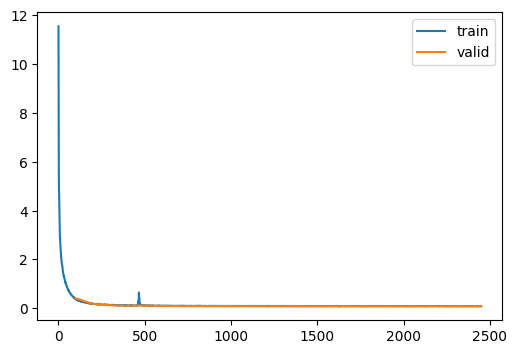

In [46]:
unpp = train(
    initialize_unet_weights_with_clf_weights(clf, TinyUnet.kaiming()),
    dls,
    loss_fn=custom_loss,
)

In [47]:
with torch.no_grad():
    yp = unpp(xb.to(def_device)).cpu()

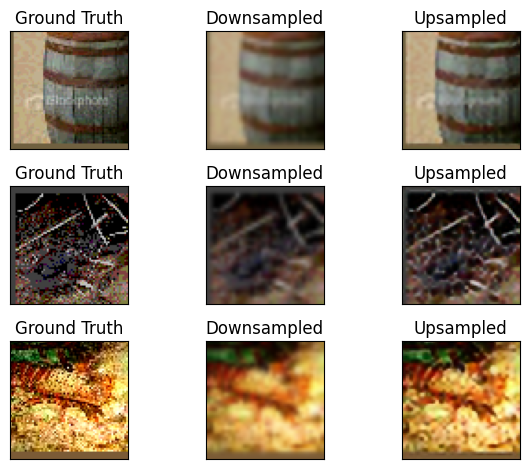

In [48]:
viz(xb, yb, yp)

In [58]:
del unpp

## U-net with residual link processing (cross-convolutions)

In [15]:
# |export
class TinyUnetWithCrossConvolutions(TinyUnet):
    def __init__(
        self,
        nfs: list[int] = (32, 64, 128, 256, 512, 1024),
        n_blocks=(3, 2, 2, 1, 1),
    ):
        super().__init__(nfs, n_blocks)
        self.cross_convs = nn.ModuleList()
        for c_in in nfs[1:]:
            cross_conv = ResidualConvBlock(c_in, c_in, stride=1)
            self.cross_convs.append(cross_conv)

    def forward(self, x):
        x = self.start(x)
        x_orig = x.clone()
        xs = []
        for l in self.downsamplers:
            x = l(x)
            xs.append(x.clone())
        for xu, l, cc in zip(reversed(xs), self.upsamplers, reversed(self.cross_convs)):
            x = l(x + cc(xu))
        x = self.final(x + x_orig)
        return x

In [16]:
dls2 = DataLoaders.from_dsd(dls.splits, bs=512).listify(
    ["image_low_rez", "image_high_rez"]
)

loss,epoch,train
2.813,0,train
0.484,0,eval
0.325,1,train
0.239,1,eval
0.201,2,train
0.177,2,eval
0.156,3,train
0.130,3,eval
0.134,4,train
0.116,4,eval


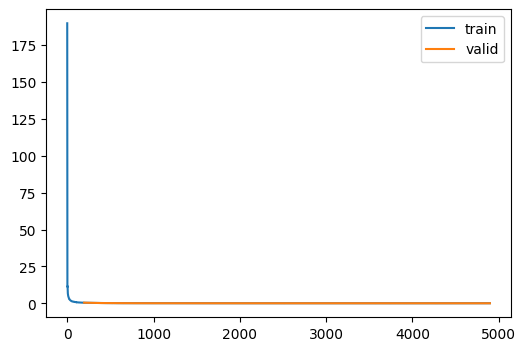

In [17]:
unc = train(TinyUnetWithCrossConvolutions.kaiming(), dls2, loss_fn=F.mse_loss)

Compare to `0.089` for the comparable U-net with MSE loss.

In [18]:
with torch.no_grad():
    yp = unc(xb.to(def_device)).cpu()

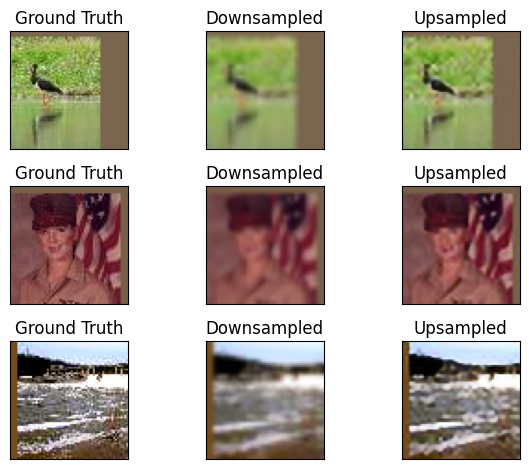

In [19]:
viz(xb, yb, yp)

In [3]:
#| hide
import nbdev

nbdev.nbdev_export()